# Capstone 2 - Music, Tweets and Language 
***

Music has always been an interest of mine. Personally it helps me be me. I can listen to it to relax, to focus, to work out and so much more. Besides what it can do at a personal level, music has the ability to connect people in ways they may or may not now. Thanks to the ever growing use of social media and technology, these connections are formed even more frequently. For my second capstone, I'm interested in seeing if twitter users with similar music interests can be identified by their tweets. 

Using previously scraped and cleaned twitter data, I will perform some exploratory data analysis below. See the Scrape Tweets and DataWrangle notebooks for more information on how I acquired the data.
***

## Exploratory Data Analysis

In [1]:
# import necessary packages and libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
from scipy.stats import norm
import numpy as np
import scipy as sp
import pickle
import spacy
import nltk
import re
from collections import Counter
import emojis

nlp = spacy.load('en_core_web_sm')

In [2]:
# Load in data
with open('data/tweets.pickle', 'rb') as b:
    tweets = pickle.load(b)

## Preprocessing Steps
1. Expanding contractions.
2. Lowercase words.
3. Remove punctuation.
4. Lemmatize text

In [3]:
# Contraction Map to be used to expand contractions 
CONTRACTION_MAP = {
"ain't": "is not", "aren't": "are not", "can't": "cannot", "can't've": "cannot have", "'cause": "because", 
"could've": "could have", "couldn't": "could not", "couldn't've": "could not have", "didn't": "did not", "doesn't": "does not",
"don't": "do not", "hadn't": "had not", "hadn't've": "had not have", "hasn't": "has not", "haven't": "have not",
"he'd": "he would", "he'd've": "he would have", "he'll": "he will", "he'll've": "he will have", "he's": "he is",
"how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is", "I'd": "I would", 
"I'd've": "I would have", "I'll": "I will", "I'll've": "I will have", "I'm": "I am", "I've": "I have", "i'd": "i would", 
"i'd've": "i would have", "i'll": "i will", "i'll've": "i will have", "i'm": "i am", "i've": "i have", "isn't": "is not",
"it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have", "it's": "it is", 
"let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have", "mightn't": "might not",
"mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", 
"needn't": "need not", "needn't've": "need not have", "o'clock": "of the clock", "oughtn't": "ought not", 
"oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
"she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have",
"she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have",
"so's": "so as", "that'd": "that would", "that'd've": "that would have", "that's": "that is","there'd": "there would",
"there'd've": "there would have", "there's": "there is", "they'd": "they would", "they'd've": "they would have",
"they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
"wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have",
"we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have",
"what're": "what are", "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have",
"where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have",
"who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not",
"won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have",
"y'all": "you all", "y'all'd": "you all would", "y'all'd've": "you all would have", "y'all're": "you all are",
"y'all've": "you all have", "you'd": "you would", "you'd've": "you would have", "you'll": "you will", 
"you'll've": "you will have", "you're": "you are", "you've": "you have"
}


def expand_contractions(text, contraction_mapping=CONTRACTION_MAP):
    """Expand contractions in given column of a dataframe if found in the CONTRACTION_MAP"""
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), 
                                      flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
                                if contraction_mapping.get(match)\
                                else contraction_mapping.get(match.lower())                       
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction
        
    expanded_text = contractions_pattern.sub(expand_match, str(text))
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text


def remove_special_characters(text, remove_digits=False):
    """Removes special characters. If you set remove_digits to true it will also remove digits"""
    pattern = r'[^a-zA-z0-9\s]' if not remove_digits else r'[^a-zA-z\s]'
    text = re.sub(pattern, '', text)
    return text

def lemmatize_text(text):
    """Use spacy to lemmatize the text"""
    text = nlp(text)
    text = ' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in text])
    return text

tokenizer = nltk.tokenize.ToktokTokenizer()
stopword_list = nltk.corpus.stopwords.words('english')

def remove_stopwords(text, is_lower_case=False):
    """Remove stopwords from text"""
    # Tokenize text to separate words
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    # If is_lower_case is false, apply stopwords filter, otherwise lower the case for everything first
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text


def normalize_corpus(corpus, contraction_expansion=True, text_lower_case=True, 
                     text_lemmatization=True, special_char_removal=True, 
                     stopword_removal=True, remove_digits=True):
    """Normalize each document in the corpus. Functions can be excluded by changing the parameter to False"""
    normalized_corpus = []
    # normalize each document in the corpus
    for doc in corpus:
        # expand contractions    
        if contraction_expansion:
            doc = expand_contractions(doc)
        # lowercase the text    
        if text_lower_case:
            doc = doc.lower()
        # remove extra newlines
        doc = re.sub(r'[\r|\n|\r\n]+', ' ',doc)
        # lemmatize text
        if text_lemmatization:
            doc = lemmatize_text(doc)
        # remove special characters and\or digits    
        if special_char_removal:
            # insert spaces between special characters to isolate them    
            special_char_pattern = re.compile(r'([{.(-)!}])')
            doc = special_char_pattern.sub(" \\1 ", doc)
            doc = remove_special_characters(doc, remove_digits=remove_digits)  
        # remove extra whitespace
        doc = re.sub(' +', ' ', doc)
        # remove stopwords
        if stopword_removal:
            doc = remove_stopwords(doc, is_lower_case=text_lower_case)
            
        normalized_corpus.append(doc)
        
    return normalized_corpus

In [4]:
tweets['cleaned'] = normalize_corpus(tweets['tweet'])

__Reset Index__

In [5]:
tweets2 = tweets.reset_index()
tweets2 = tweets2.drop(['index'], axis=1)

__Remove any tweets that are not in English__

In [6]:
from langdetect import detect

for i in range(len(tweets2)):
    try:
        if detect(str(tweets2['cleaned'][i])) != 'en':   # If the language detected is not english, drop the row
            tweets2.drop(i, inplace=True)
    except:     # Pass the loop if no language can be identified
        pass

In [7]:
# Encode Genre Category: 0-Country, 1-EDM, 2-Hip-Hop, 3-Jazz, 4-Metal Rock
tweets2["Genre"] = tweets2["Genre"].astype('category')
tweets2["genre_cat"] = tweets2["Genre"].cat.codes

In [8]:
# Extract unique emojis from each tweet into the a new "emojis" column
tweets2['emojis'] = [emojis.decode(x) for x in tweets2['tweet']]
tweets2['emojis'] = [re.findall(r':(.*?):', x) for x in tweets2['emojis']]

In [9]:
tweets2.head()

,username,tweet,mentions,hashtags,retweet,Genre,word_count,cleaned,genre_cat,emojis
0,00sarrett,I got 5 others outta the bargain bin but they ...,[],[],False,EDM,50,get outta bargain bin one want add collection ...,1,[]
1,00sarrett,I do believe I’ve determined a suitable replac...,[],[#forwardthinking],False,EDM,46,believe determine suitable replacement twa ind...,1,[joy]
2,00sarrett,Both just started watching and finished The Se...,[],[],False,EDM,38,start watch finish seven deadly sin anime coup...,1,"[100, hearts]"
3,00sarrett,I got an offer today to move to another state ...,[],[#decisions],False,EDM,28,get offer today move another state bunk old fr...,1,[]
4,00sarrett,"Roflmao 😂 no doubt haha, this is the extent of...",[gabri_rae],[],False,EDM,28,roflmao doubt haha extent disagreement ever ac...,1,"[joy, 100]"


## Predictive Features

Features and word can tell us a lot about something to gain more insights. To examine this I will be looking at the words in each group of tweets as well as the emojis that people are using. Let's see what we can find.

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split

In [11]:
tfidf_vect = TfidfVectorizer(min_df=1, ngram_range=(1, 2))

In [12]:
def get_predictive_features(vectorizer, test_set, classifier, category):
    """ 
    This function takes into account the vectorizer, test set, and classifier to output the predictive features of a dataset.
    """
    
    words = np.array(vectorizer.get_feature_names())
    x = np.eye(test_set.shape[1])
    probs = classifier.predict_log_proba(x)[:,category]
    ind = np.argsort(probs)
    
    high_words = words[ind[:10]]
    low_words = words[ind[-10:]]

    high_prob = probs[ind[:10]]
    low_prob = probs[ind[-10:]]

    print("High Words\t     P(high | word)")
    for w, p in zip(high_words, high_prob):
        print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))
    
    print("Low Words\t     P(low | word)")
    for w, p in zip(low_words, low_prob):
        print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))

In [13]:
# Store tweet dataset into feature matrix and response vector
X_words = tweets2['cleaned']
y_words = tweets2['genre_cat']

# Instantiate TfidfVectorizer
tfidf_vect_words = TfidfVectorizer(min_df=10, ngram_range=(1, 2))

# Apply TfidfVectorizer
X_words = tfidf_vect_words.fit_transform(tweets2['cleaned'].apply(str))
X_words = X_words.tocsc() 

# Split dataset into train/test data
Xtrain_w, Xtest_w, ytrain_w, ytest_w = train_test_split(X_words, y_words, random_state=17)

# Instantiate multinomialNB() for TfidfVectorizer
nb_words = MultinomialNB(alpha=1, fit_prior=True)

# Train model
nb_words.fit(Xtrain_w, ytrain_w)

MultinomialNB(alpha=1, class_prior=None, fit_prior=True)

In [14]:
# Store tweet dataset into feature matrix and response vector
X_emojis = tweets2['emojis']
y_emojis = tweets2['genre_cat']

# Instantiate TfidfVectorizer
tfidf_vect_emojis = TfidfVectorizer(min_df=10, ngram_range=(1, 2))

# Apply TfidfVectorizer
X_emojis = tfidf_vect_emojis.fit_transform(tweets2['emojis'].apply(str))
X_emojis = X_emojis.tocsc() 

# Split dataset into train/test data
Xtrain_e, Xtest_e, ytrain_e, ytest_e = train_test_split(X_emojis, y_emojis, random_state=17)

# Instantiate multinomialNB() for TfidfVectorizer
nb_emojis = MultinomialNB(alpha=1, fit_prior=True)

# Train model
nb_emojis.fit(Xtrain_e, ytrain_e)

MultinomialNB(alpha=1, class_prior=None, fit_prior=True)

## Word Counts, Word Frequencies and Word Clouds
It is also interesting to see the word counts, most frequent words visuzlalized to see what people are using and saying.

In [15]:
tweets2['word_count'] = tweets2['cleaned'].apply(lambda x: len(str(x).split(" ")))

In [16]:
edm = tweets2[tweets2['Genre'] == 'EDM'].reset_index().drop(['index'], axis=1)
country = tweets2[tweets2['Genre'] == 'Hip-Hop'].reset_index().drop(['index'], axis=1)
hiphop = tweets2[tweets2['Genre'] == 'EDM'].reset_index().drop(['index'], axis=1)
jazz = tweets2[tweets2['Genre'] == 'Jazz'].reset_index().drop(['index'], axis=1)
metal = tweets2[tweets2['Genre'] == 'Metal Rock'].reset_index().drop(['index'], axis=1)

In [17]:
from wordcloud import WordCloud
from nltk import word_tokenize

def word_freq_plot(df, col):
    """Take a column from a dataframe and split the words within each review. Then combine them back together into one list.
       After create a frequency distribution plot to determine the frequency of the words.
    """
    words = "".join(df[col].apply(str)).split()
    freqdist = nltk.FreqDist(words)
    freqdist.plot(25)
    
def word_cloud(df, col):
    """Take a given column of reviews and create a word cloud from it."""
    
    all_words = ''
    df[col].dropna(inplace=True)
    for val in df[col]:
        tokens = word_tokenize(val)
        for words in tokens:
            all_words = all_words + ' ' + words
        
    wordcloud = WordCloud(max_words=1000, width=600, height=400).generate(all_words)
    
    plt.figure( figsize=(10,8), facecolor='black')
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show()

***

I will split everything I mentioned above by genre of music for clarity. 

### Country

Predictive Features: Words

High Words	     P(high | word)
                  vs 0.94
                  rt 0.94
               fight 0.93
            business 0.92
                fuck 0.91
                club 0.91
              report 0.91
                 mad 0.91
             twitter 0.91
                page 0.91
Low Words	     P(low | word)
         schearthome 0.54
   hmnow schearthome 0.54
      meandyouseason 0.54
whenhopecall meandyouseason 0.54
        whenhopecall 0.54
               hmnow 0.54
heartie whenhopecall 0.54
meandyouseason hmnow 0.54
            thursday 0.54
             amazing 0.50


Predictive Features: Emojis

High Words	     P(high | word)
           male_sign 0.95
  facepalm male_sign 0.94
                pray 0.94
                 you 0.93
           pray pray 0.91
         sweat_smile 0.91
                 for 0.91
     shrug male_sign 0.90
        broken_heart 0.89
smiling_face_with_three_hearts 0.89
Low Words	     P(low | word)
             sob sob 0.6

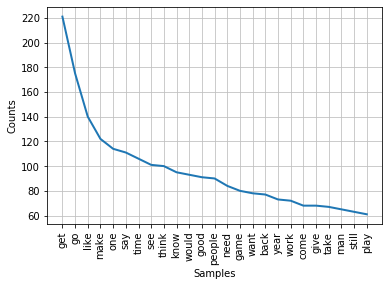



 Word Cloud:


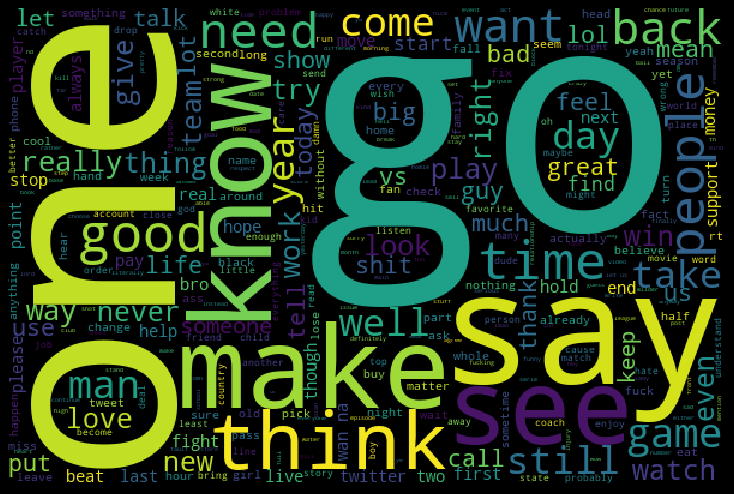

In [18]:
print("Predictive Features: Words\n")
get_predictive_features(vectorizer=tfidf_vect_words, test_set=X_words ,classifier=nb_words, category=0)

print("\n\nPredictive Features: Emojis\n")
get_predictive_features(vectorizer=tfidf_vect_emojis, test_set=X_emojis ,classifier=nb_emojis, category=0)

print("\n\n Word Frequency Plot:")
word_freq_plot(country, "cleaned")

print("\n\n Word Cloud:")
word_cloud(country, "cleaned")

### EDM

Predictive Features: Words

High Words	     P(high | word)
           important 0.94
                hold 0.93
               trump 0.93
                cast 0.93
                 bro 0.93
               story 0.92
             believe 0.92
              member 0.92
     realdonaldtrump 0.92
               maybe 0.92
Low Words	     P(low | word)
             go live 0.58
               vegas 0.58
                  rn 0.57
wodify ctowncrossfit 0.56
         ctownstrong 0.56
ctowncrossfit ctownstrong 0.56
              wodify 0.56
       ctowncrossfit 0.56
               chill 0.56
               india 0.51


Predictive Features: Emojis

High Words	     P(high | word)
           male_sign 0.94
                 cry 0.94
               blush 0.94
slightly_smiling_face 0.93
  facepalm male_sign 0.93
            thinking 0.93
        broken_heart 0.93
                eyes 0.93
stuck_out_tongue_winking_eye 0.92
           fire fire 0.90
Low Words	     P(low | word)
                fire 0.73
 

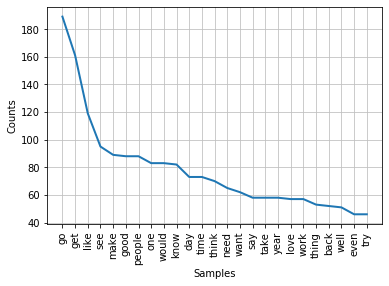



 Word Cloud:


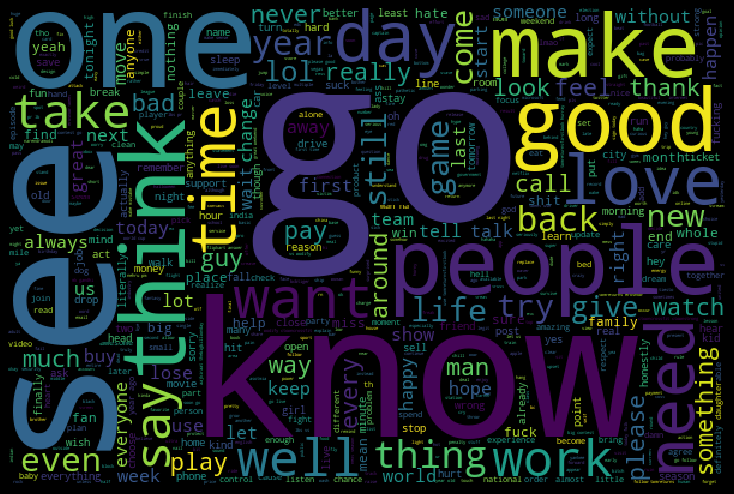

In [19]:
print("Predictive Features: Words\n")
get_predictive_features(vectorizer=tfidf_vect_words, test_set=X_words ,classifier=nb_words, category=1)

print("\n\nPredictive Features: Emojis\n")
get_predictive_features(vectorizer=tfidf_vect_emojis, test_set=X_emojis ,classifier=nb_emojis, category=1)

print("\n\n Word Frequency Plot:")
word_freq_plot(edm, "cleaned")

print("\n\n Word Cloud:")
word_cloud(edm, "cleaned")

### Hip Hop

Predictive Features: Words

High Words	     P(high | word)
                 cat 0.91
              simple 0.91
              remove 0.91
           seriously 0.90
                 yes 0.90
                ship 0.90
              flight 0.90
               clean 0.90
               india 0.90
            recently 0.90
Low Words	     P(low | word)
                half 0.57
                lord 0.57
                club 0.56
              africa 0.56
                kick 0.54
               italy 0.53
                  vs 0.53
                  rt 0.51
               homie 0.48
                 bro 0.41


Predictive Features: Emojis

High Words	     P(high | word)
          two_hearts 0.94
               heart 0.93
    upside_down_face 0.93
        purple_heart 0.92
               blush 0.91
facepalm female_sign 0.91
              hearts 0.91
     sparkling_heart 0.90
stuck_out_tongue_winking_eye 0.90
       pleading_face 0.90
Low Words	     P(low | word)
                eyes 0.65
       

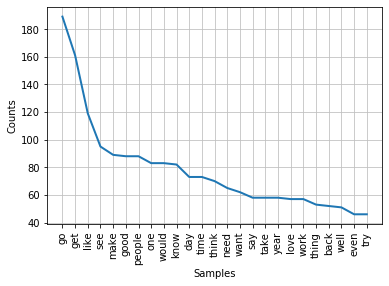



 Word Cloud:


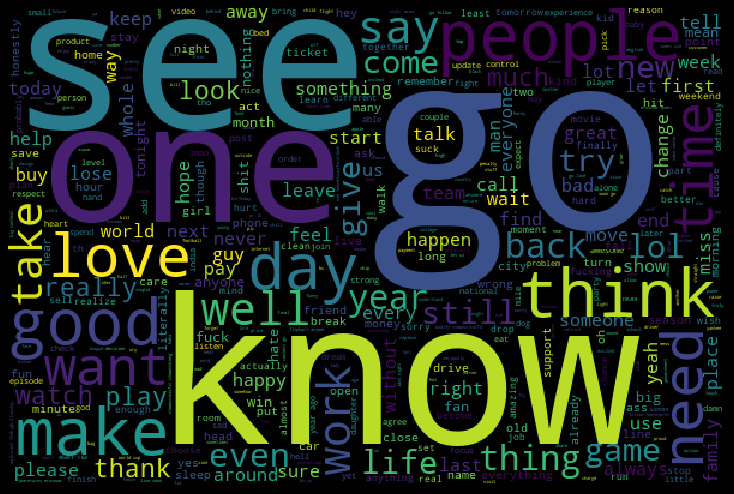

In [20]:
print("Predictive Features: Words\n")
get_predictive_features(vectorizer=tfidf_vect_words, test_set=X_words ,classifier=nb_words, category=2)

print("\n\nPredictive Features: Emojis\n")
get_predictive_features(vectorizer=tfidf_vect_emojis, test_set=X_emojis ,classifier=nb_emojis, category=2)

print("\n\n Word Frequency Plot:")
word_freq_plot(hiphop, "cleaned")

print("\n\n Word Cloud:")
word_cloud(hiphop, "cleaned")

### Jazz

Predictive Features: Words

High Words	     P(high | word)
           literally 0.95
                 tho 0.94
                yeah 0.94
             deserve 0.94
             finally 0.94
                 buy 0.93
               bitch 0.93
                fuck 0.93
               night 0.93
               movie 0.93
Low Words	     P(low | word)
               north 0.61
              racist 0.60
           committee 0.59
               obama 0.59
                fake 0.58
             student 0.56
              member 0.56
        constitution 0.56
               trump 0.55
                 gop 0.53


Predictive Features: Emojis

High Words	     P(high | word)
         sweat_smile 0.95
           roll_eyes 0.95
          two_hearts 0.93
             ok_hand 0.93
                fire 0.93
        purple_heart 0.92
     sparkling_heart 0.92
      expressionless 0.92
                clap 0.91
              hearts 0.91
Low Words	     P(low | word)
  facepalm male_sign 0.75
               

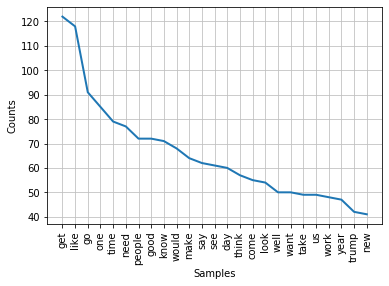



 Word Cloud:


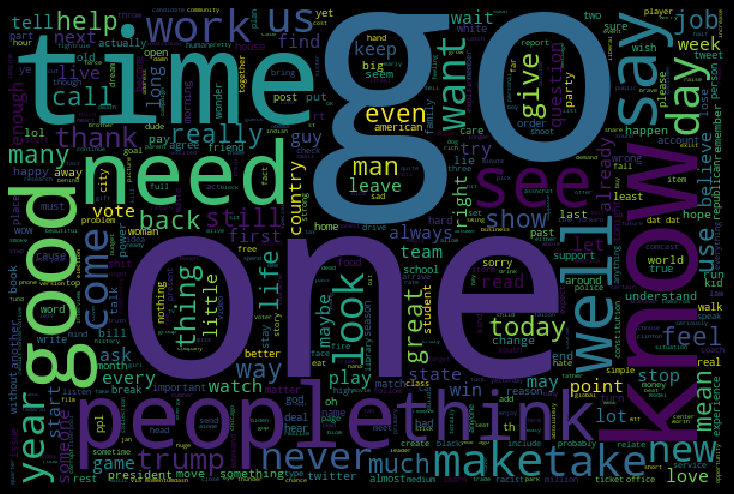

In [21]:
print("Predictive Features: Words\n")
get_predictive_features(vectorizer=tfidf_vect_words, test_set=X_words ,classifier=nb_words, category=3)

print("\n\nPredictive Features: Emojis\n")
get_predictive_features(vectorizer=tfidf_vect_emojis, test_set=X_emojis ,classifier=nb_emojis, category=3)

print("\n\n Word Frequency Plot:")
word_freq_plot(jazz, "cleaned")

print("\n\n Word Cloud:")
word_cloud(jazz, "cleaned")

### Metal Rock

Predictive Features: Words

High Words	     P(high | word)
                  rt 0.93
                half 0.92
        relationship 0.91
            thursday 0.91
                  th 0.91
                gift 0.91
               voice 0.90
             penalty 0.90
             teacher 0.90
             offense 0.90
Low Words	     P(low | word)
               image 0.59
               bitch 0.59
               death 0.59
                sort 0.59
            nowplaye 0.57
              battle 0.57
                left 0.53
             compare 0.52
               metal 0.49
     spainsitandtalk 0.48


Predictive Features: Emojis

High Words	     P(high | word)
                 the 0.93
                fire 0.93
                clap 0.92
                  in 0.92
slightly_smiling_face 0.91
              hearts 0.91
                 and 0.91
                 100 0.90
                  me 0.89
heart_eyes heart_eyes 0.88
Low Words	     P(low | word)
                 for 0.72
             

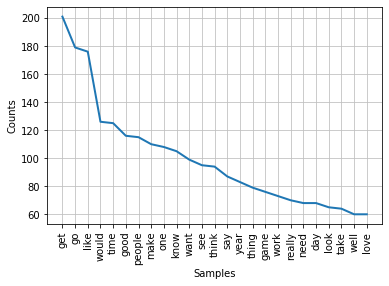



 Word Cloud:


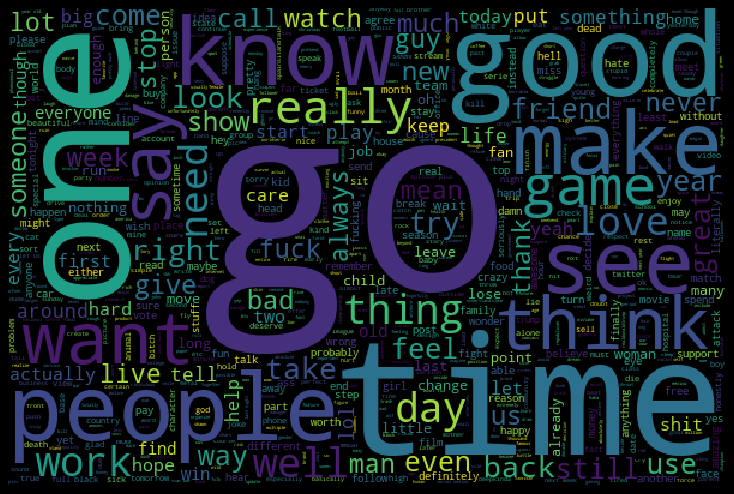

In [22]:
print("Predictive Features: Words\n")
get_predictive_features(vectorizer=tfidf_vect_words, test_set=X_words ,classifier=nb_words, category=4)

print("\n\nPredictive Features: Emojis\n")
get_predictive_features(vectorizer=tfidf_vect_emojis, test_set=X_emojis ,classifier=nb_emojis, category=4)

print("\n\n Word Frequency Plot:")
word_freq_plot(metal, "cleaned")

print("\n\n Word Cloud:")
word_cloud(metal, "cleaned")

In [23]:
tweets.to_pickle('tweetsML.pickle')